<a href="https://colab.research.google.com/github/lbenbaccar/Toxic-Comment-Classification-Challenge/blob/main/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Toxic comments classification challenge</center>

In [1]:
!pip install emoji
!pip install demoji
!pip install contractions
!pip install plot_keras_history
!pip install --upgrade tables
!pip install --pre --upgrade gensim
#!pip install "seaborn == 0.10.1"
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 529.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=8cb6624fe72f9518375b5619839251ff88ad9dafbb084bd90529010e3baa18e1
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=22d1be755e7bf9422f2772e45e862fb1f

In [2]:
import numpy as np
from numpy import asarray
from numpy import zeros
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import scipy.special
from scipy import sparse
from scipy.sparse import hstack
import matplotlib_venn as venn
import os

import time
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import emoji
import demoji
import contractions
from textblob import TextBlob
from gensim.models import Word2Vec
import multiprocessing
import string

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, multilabel_confusion_matrix, roc_auc_score, average_precision_score, recall_score, precision_score, matthews_corrcoef, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow. keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LSTM, Embedding, Input, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Flatten
from tensorflow.keras.initializers import Constant
from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel, create_optimizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple, List
from functools import partial
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data exploration

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP - ENSAE/train.csv')
train_df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [6]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP - ENSAE/test.csv')
test_df.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [7]:
train_df.describe(include = 'all').transpose()

count  unique  \
id               159571  159571   
comment_text     159571  159571   
toxic          159571.0     NaN   
severe_toxic   159571.0     NaN   
obscene        159571.0     NaN   
threat         159571.0     NaN   
insult         159571.0     NaN   
identity_hate  159571.0     NaN   

                                                             top freq  \
id                                              0000997932d777bf    1   
comment_text   Explanation\nWhy the edits made under my usern...    1   
toxic                                                        NaN  NaN   
severe_toxic                                                 NaN  NaN   
obscene                                                      NaN  NaN   
threat                                                       NaN  NaN   
insult                                                       NaN  NaN   
identity_hate                                                NaN  NaN   

                   mean       std  min  25%  50%  75%  max  
id                  NaN       NaN  NaN  NaN  NaN  NaN  NaN  
comment_text        NaN       NaN  NaN  NaN  NaN  NaN  NaN  
toxic          0.095844  0.294379  0.0  0.0  0.0  0.0  1.0  
severe_toxic   0.009996  0.099477  0.0  0.0  0.0  0.0  1.0  
obscene        0.052948  0.223931  0.0  0.0  0.0  0.0  1.0  
threat         0.002996   0.05465  0.0  0.0  0.0  0.0  1.0  
insult         0.049364  0.216627  0.0  0.0  0.0  0.0  1.0  
identity_hate  0.008805   0.09342  0.0  0.0  0.0  0.0  1.0

In [8]:
train_df.shape

(159571, 8)

In [9]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [10]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [11]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum())
print()
print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [12]:
x=train_df.iloc[:,2:].sum()

rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

train_df['clean'].sum()
print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total toxic comments = ",len(train_df[train_df['clean']!=1]))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total toxic comments =  16225
Total tags = 35098


## 2. Data pre-processing

In [13]:
train_df["split"] = "TRAIN"
test_df["split"] = "TEST"

In [14]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
312730  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...   
312731  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...   
312732  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...   
312733  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...   
312734  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate clean  \
0         0.0           0.0      0.0     0.0     0.0            0.0  True   
1         0.0           0.0      0.0     0.0     0.0            0.0  True   
2         0.0           0.0      0.0     0.0     0.0            0.0  True   
3         0.0           0.0      0.0     0.0     0.0            0.0  True   
4         0.0           0.0      0.0     0.0     0.0            0.0  True   
...       ...           ...      ...     ...     ...            ...   ...   
312730    NaN           NaN      NaN     NaN     NaN            NaN   NaN   
312731    NaN           NaN      NaN     NaN     NaN            NaN   NaN   
312732    NaN           NaN      NaN     NaN     NaN            NaN   NaN   
312733    NaN           NaN      NaN     NaN     NaN            NaN   NaN   
312734    NaN           NaN      NaN     NaN     NaN            NaN   NaN   

        split  
0       TRAIN  
1       TRAIN  
2       TRAIN  
3       TRAIN  
4       TRAIN  
...       ...  
312730   TEST  
312731   TEST  
312732   TEST  
312733   TEST  
312734   TEST  

[312735 rows x 10 columns]

### 2.1) Features extractions

In [15]:
# Comments in capitals
df['capitals'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df["uppercase_comments"] = df['comment_text'].apply(lambda x: 1 if x.isupper() else 0)

In [16]:
# Number of punctuations in comments
df['punctuations'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [17]:
# Number of characters in comments
df['length'] = df['comment_text'].apply(len)

In [18]:
# Number of sentences
df['sentences'] = df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [19]:
# Number of words
df['words'] = df["comment_text"].apply(lambda x: len(str(x).split()))

In [20]:
# Number of emojis in comments
df['emojis'] = df['comment_text'].apply(lambda comment: emoji.emoji_count(comment))

### 2.2) Data cleaning

In [21]:
df["clean_comments"] = df["comment_text"].apply(lambda x: x.lower())

In [22]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: contractions.fix(x))

In [23]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [24]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_URL(x))

In [25]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_html(x))

In [26]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_non_ascii(x))

In [27]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_punct(x))

In [28]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
filename = "/content/drive/MyDrive/NLP - ENSAE/clean_df.hdf5"
key = "CleanData"
df.to_hdf(path_or_buf = filename,  key = key, mode='w')

<ipython-input-29-b5689df3b405>:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['id', 'comment_text', 'clean', 'split', 'clean_comments'], dtype='object')]

  df.to_hdf(path_or_buf = filename,  key = key, mode='w')


## 3. Data visualization

In [30]:
filename = "/content/drive/MyDrive/NLP - ENSAE/clean_df.hdf5"
key = "CleanData"
df = pd.read_hdf(filename, key)

In [31]:
train_df = df.loc[df.split == "TRAIN"].reset_index(drop=True)
train_df.head(3)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...    0.0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...    0.0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...    0.0   

   severe_toxic  obscene  threat  insult  identity_hate clean  split  \
0           0.0      0.0     0.0     0.0            0.0  True  TRAIN   
1           0.0      0.0     0.0     0.0            0.0  True  TRAIN   
2           0.0      0.0     0.0     0.0            0.0  True  TRAIN   

   capitals  uppercase_comments  punctuations  length  sentences  words  \
0        17                   0            10     264          2     43   
1         8                   0            12     112          1     17   
2         4                   0             6     233          1     42   

   emojis                                     clean_comments  
0       0  explanation edits made username hardcore metal...  
1       0  daww matches background colour seemingly stuck...  
2       0  hey man really trying edit war guy constantly ...

In [32]:
test_df = df.loc[df.split == "TEST"].reset_index(drop=True)
test_df.head(3)

id                                       comment_text  toxic  \
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...    NaN   
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...    NaN   
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...    NaN   

   severe_toxic  obscene  threat  insult  identity_hate clean split  capitals  \
0           NaN      NaN     NaN     NaN            NaN   NaN  TEST         4   
1           NaN      NaN     NaN     NaN            NaN   NaN  TEST         7   
2           NaN      NaN     NaN     NaN            NaN   NaN  TEST         4   

   uppercase_comments  punctuations  length  sentences  words  emojis  \
0                   0            12     367          1     72       0   
1                   0             6      50          3     12       0   
2                   0             8      54          5     12       0   

                                      clean_comments  
0  yo bitch ja rule succesful ever hating sad mof...  
1                               rfc title fine going  
2                        sources zawe ashton lapland

In [33]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

<ipython-input-34-b59e05afde2b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x.index, y=x.values, palette=colors, alpha=0.8)  # Specify colors using 'palette' argument


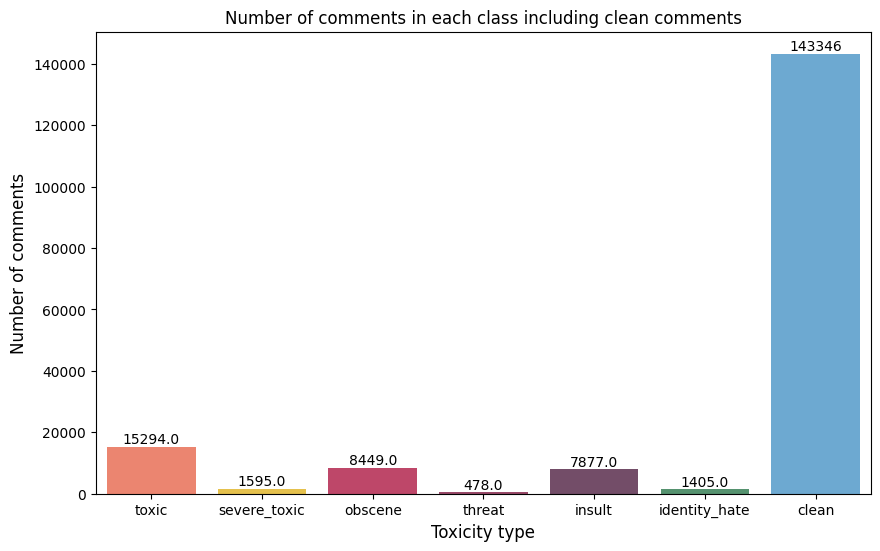

In [34]:

import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of comments in each class
x = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "clean"]].sum()

# Define colors for each category
colors = ['#FF5733', '#FFC300', '#C70039', '#900C3F', '#581845', '#1E8449', '#3498DB']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=x.index, y=x.values, palette=colors, alpha=0.8)  # Specify colors using 'palette' argument
plt.title("Number of comments in each class including clean comments")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Toxicity type', fontsize=12)

# Add labels on top of each bar
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

plt.show()

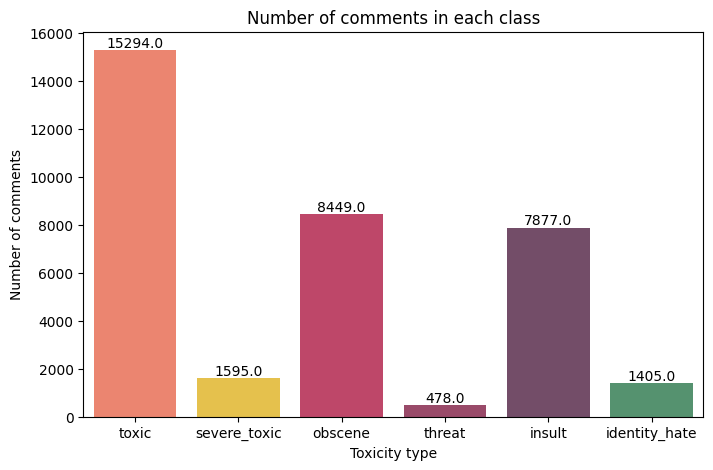

In [35]:
# Calculate value counts
val_counts = train_df[types].sum()

# Define a color palette
colors = ['#FF5733', '#FFC300', '#C70039', '#900C3F', '#581845', '#1E8449']

# Create the barplot with specified colors
plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, hue=val_counts.index, palette=colors, alpha=0.8, legend=False)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

# Add labels to the bars
rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")

# Show the plot
plt.show()



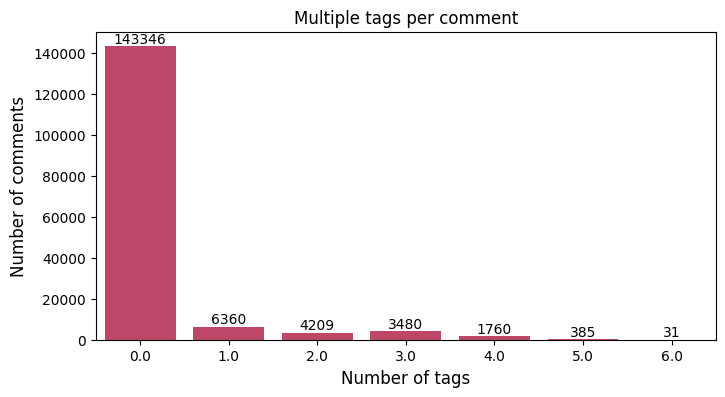

In [ ]:
# Number of classes the comment belongs to
train_df["total"] = train_df[types].sum(axis=1)
x=train_df.total.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=colors[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Axes: >

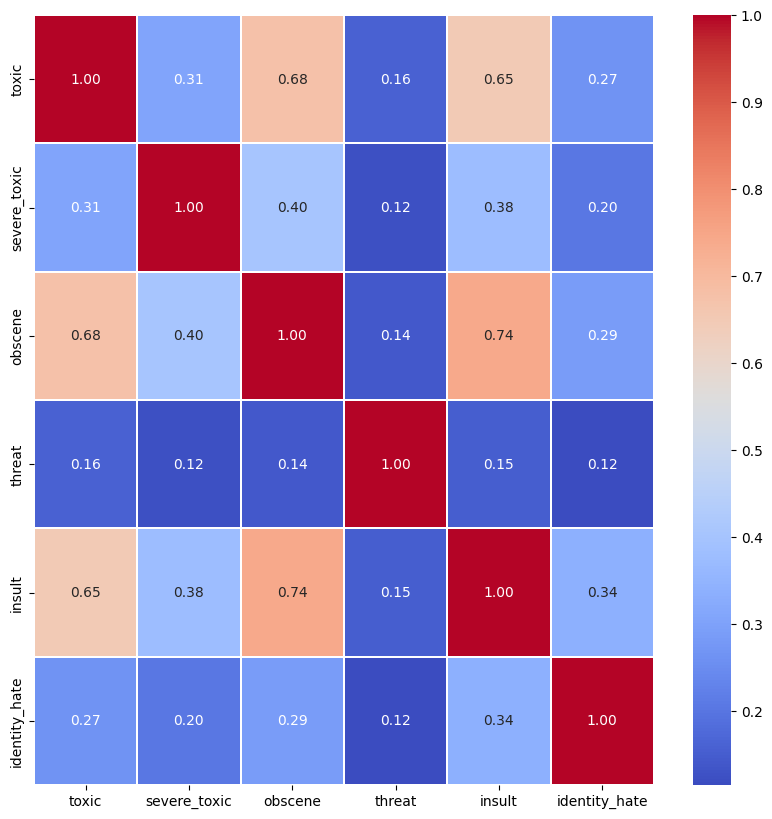

In [ ]:
temp_df = train_df[types]
corr=temp_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            cmap="coolwarm",
            fmt='.2f',
            linewidths=.05,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

<ipython-input-46-74a1faea1d8c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "length"], label="Toxic", shade=True, color='r')
<ipython-input-46-74a1faea1d8c>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "words"], label="Toxic", shade=True, color='r')
<ipython-input-46-74a1faea1d8c>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "sentences"], label="Toxic", shade=True, color='r')


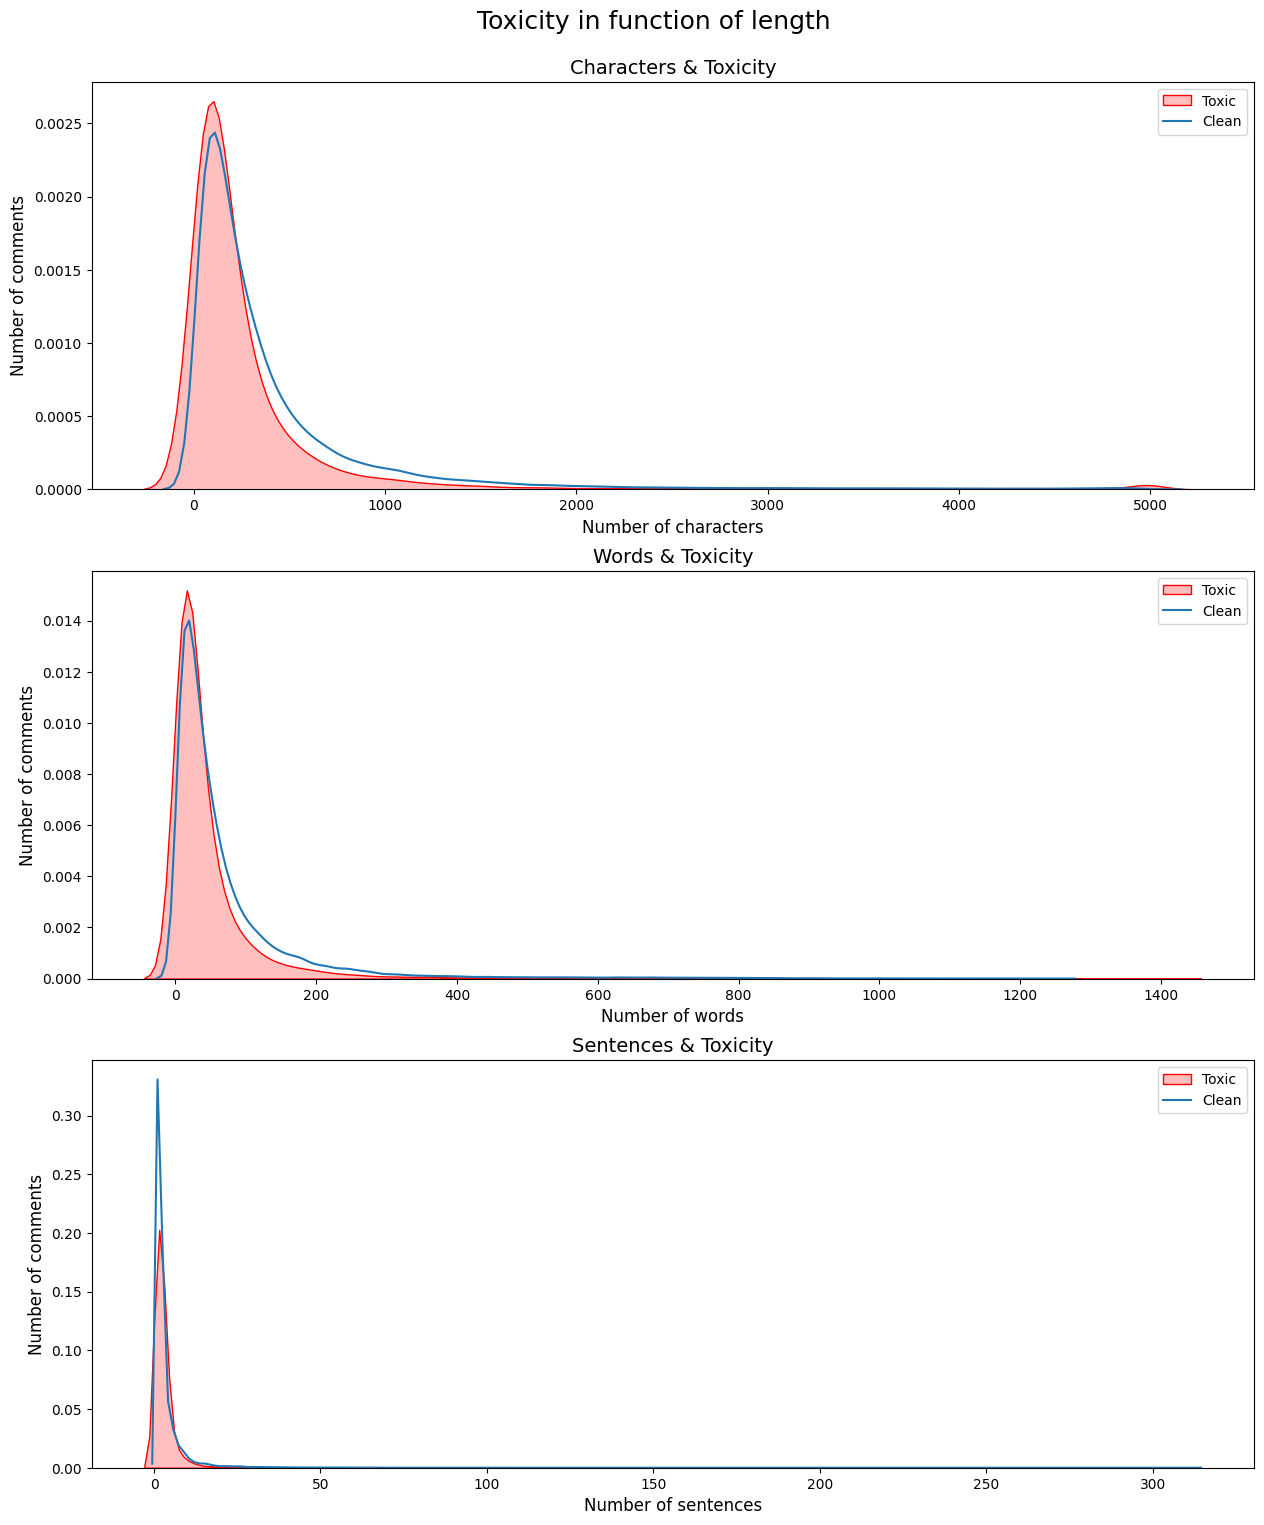

In [ ]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of length",y=0.92,fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "length"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "length"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Toxicity", fontsize=14)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "words"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "words"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Toxicity", fontsize=14)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "sentences"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "sentences"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Toxicity", fontsize=14)

plt.show()

<ipython-input-47-99b6c666d3c7>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "capitals"], label="Toxic", shade=True, color='r')
<ipython-input-47-99b6c666d3c7>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "punctuations"], label="Toxic", shade=True, color='r')
<ipython-input-47-99b6c666d3c7>:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "emojis"], label="Toxic", shade=True, color='r')


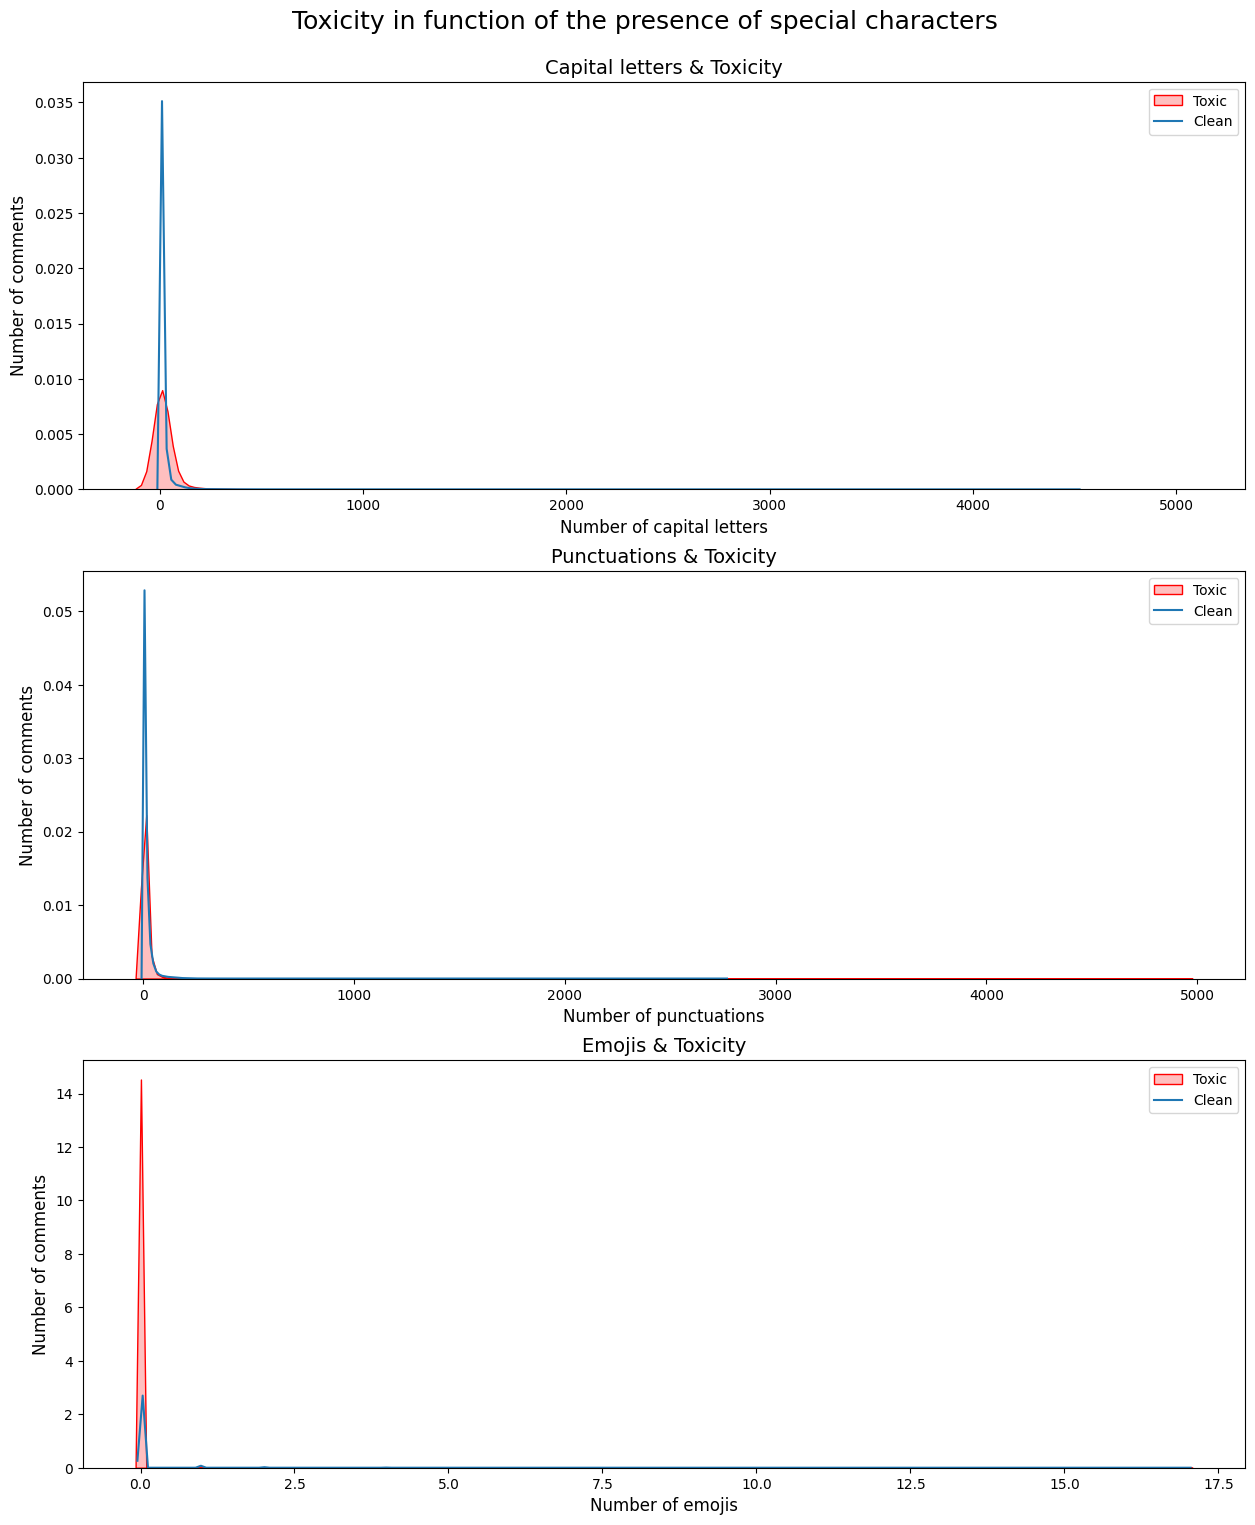

In [ ]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of the presence of special characters",y=0.92,fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "capitals"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "capitals"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=14)

plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "punctuations"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "punctuations"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=14)

plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "emojis"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "emojis"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=14)

plt.show()

In [ ]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        compteur += 1
        variables.append(str(types[i] + " & " + types[j]))
        values.append(train_df.loc[(train_df.total == 2) & (train_df[types[i]] == 1) & (train_df[types[j]] == 1)].shape[0])

In [ ]:
assert compteur == scipy.special.binom(6, 2)
assert sum(values) == train_df.loc[train_df.total == 2].shape[0]

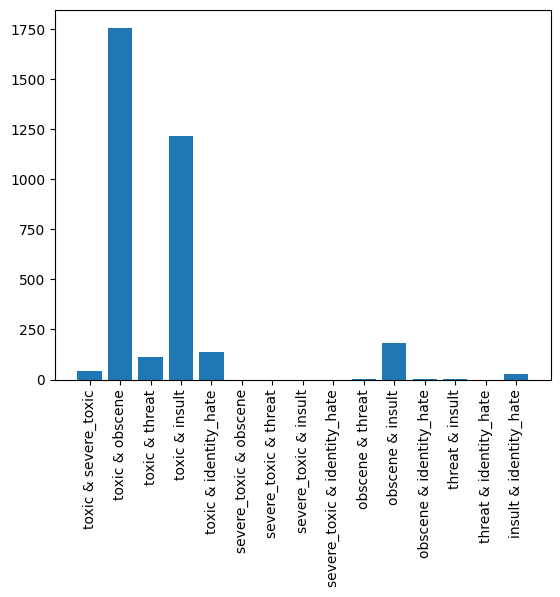

In [ ]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

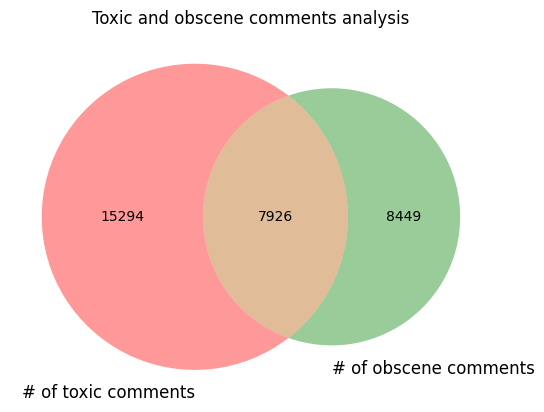

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
obscene_com = set(train_df.loc[train_df.obscene == 1, "id"].tolist())
common_com = list(toxic_com.intersection(obscene_com))
plt.title("Toxic and obscene comments analysis")
venn.venn2(subsets=(len(toxic_com),len(obscene_com),len(common_com)),set_labels=("# of toxic comments","# of obscene comments"))
plt.show()

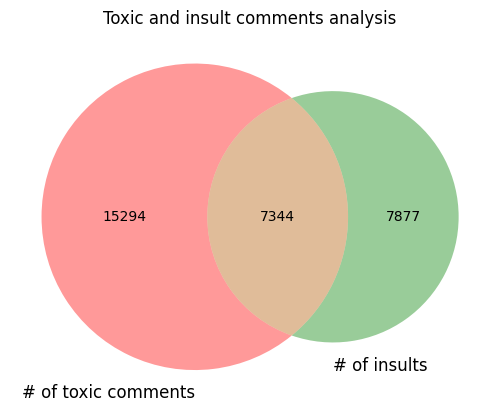

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
insult_com = set(train_df.loc[train_df.insult == 1, "id"].tolist())
common_com = list(toxic_com.intersection(insult_com))
plt.title("Toxic and insult comments analysis")
venn.venn2(subsets=(len(toxic_com),len(insult_com),len(common_com)),set_labels=("# of toxic comments","# of insults"))
plt.show()

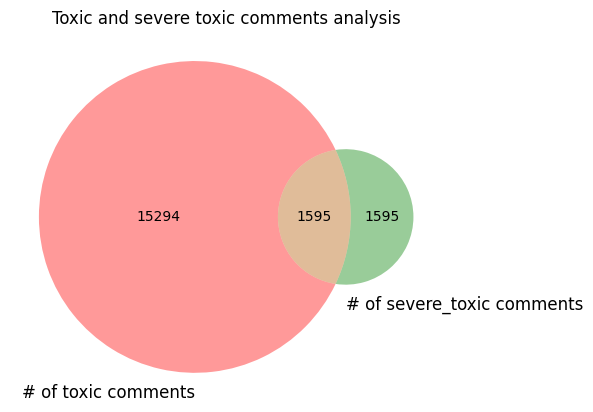

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
severe_toxic_com = set(train_df.loc[train_df.severe_toxic == 1, "id"].tolist())
common_com = list(toxic_com.intersection(severe_toxic_com))
plt.title("Toxic and severe toxic comments analysis")
venn.venn2(subsets=(len(toxic_com),len(severe_toxic_com),len(common_com)),set_labels=("# of toxic comments","# of severe_toxic comments"))
plt.show()

In [ ]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        for k in range(j+1, len(types)) :
            compteur += 1
            variables.append(str(types[i] + " & " + types[j] + " & " + types[k]))
            values.append(train_df.loc[(train_df.total == 3) &
                                       (train_df[types[i]] == 1) &
                                       (train_df[types[j]] == 1) &
                                       (train_df[types[k]] == 1)].shape[0])

In [ ]:
assert compteur == scipy.special.binom(6, 3)
assert sum(values) == train_df.loc[train_df.total == 3].shape[0]

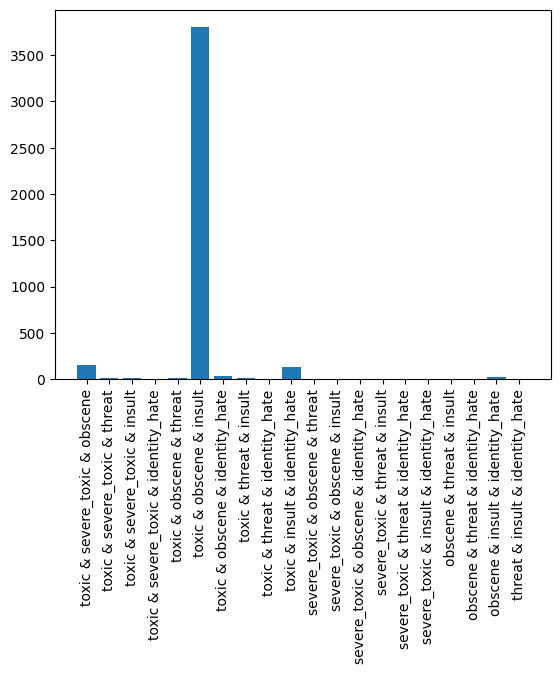

In [ ]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

In [ ]:
word_counter = {}

for categ in types:
    d = Counter()
    train_df[train_df[categ] == 1]['clean_comments'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

In [ ]:
%matplotlib inline

(-0.5, 399.5, 199.5, -0.5)

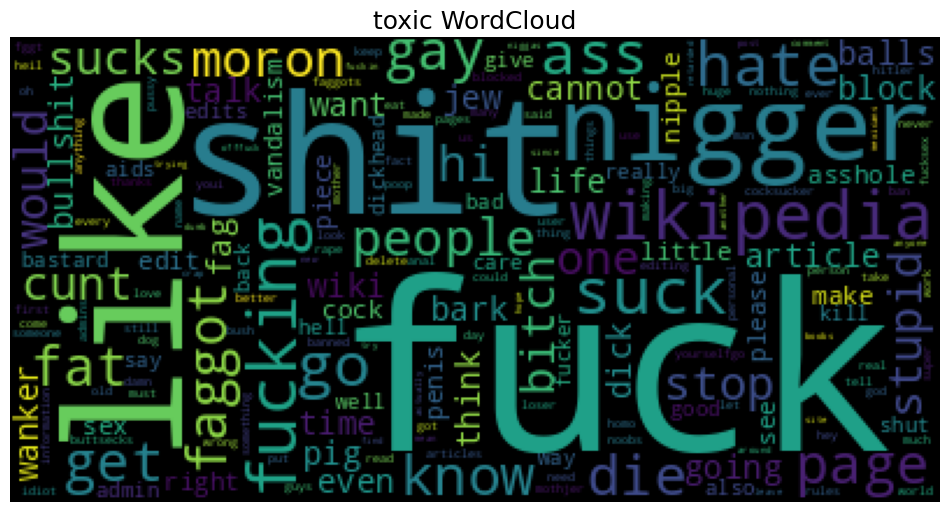

In [ ]:
w = 'toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

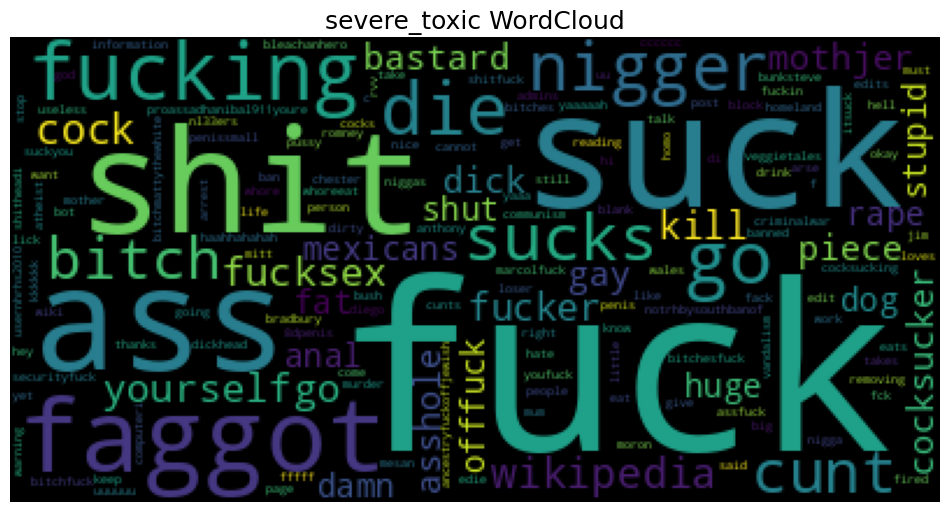

In [ ]:
w = 'severe_toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

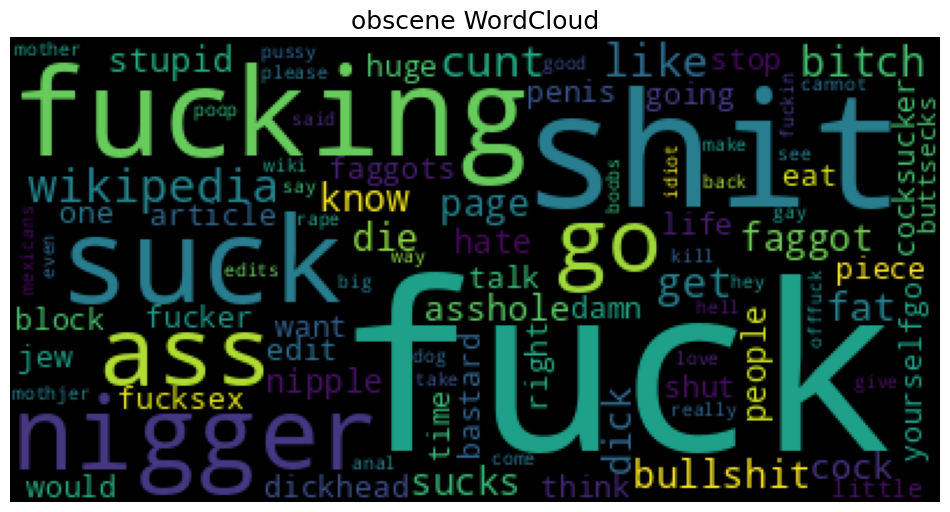

In [ ]:
w = 'obscene'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

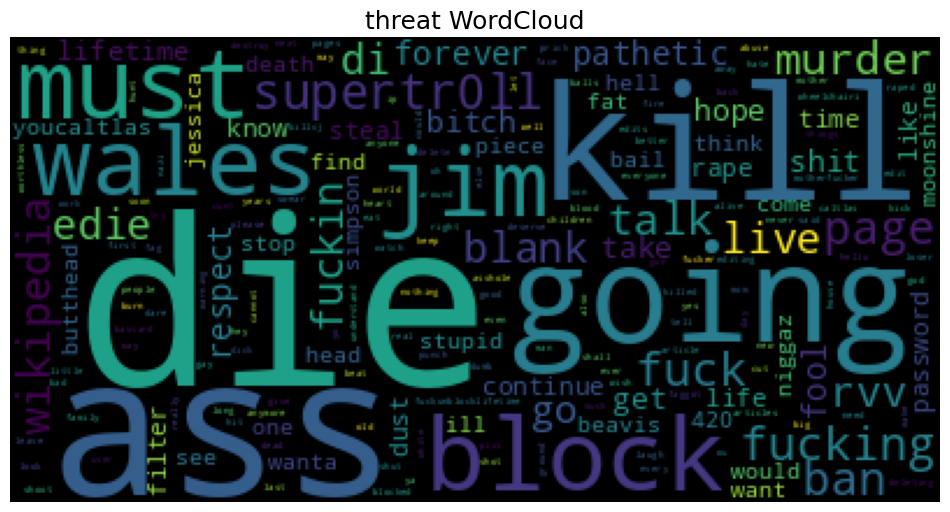

In [ ]:
w = 'threat'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

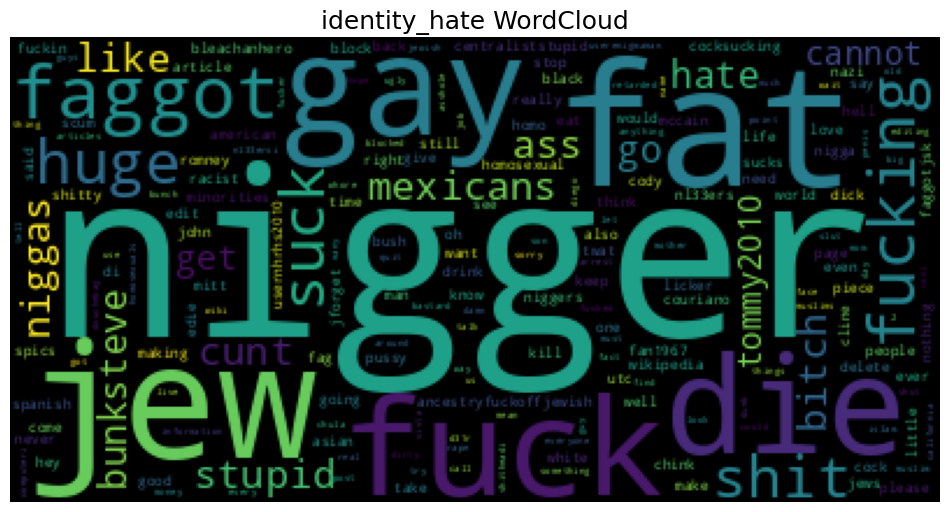

In [ ]:
w = 'identity_hate'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

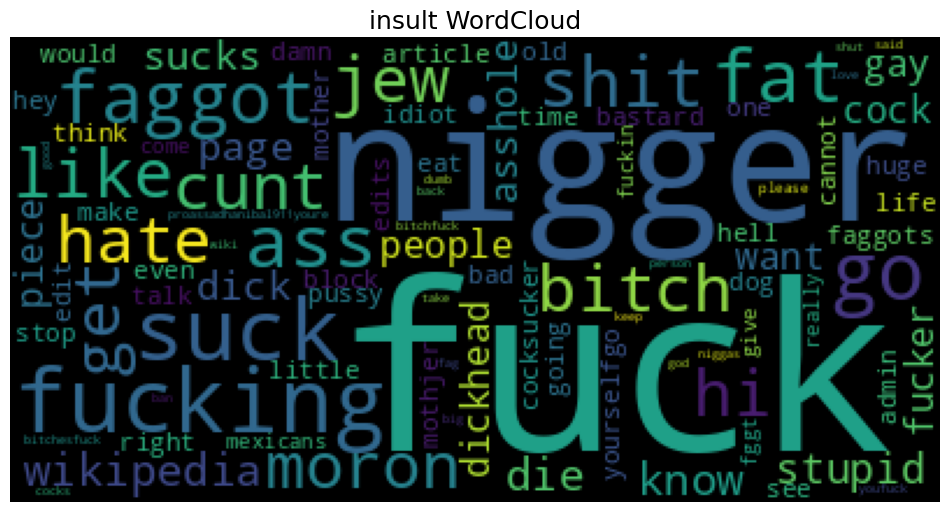

In [ ]:
w = 'insult'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

## 4. Modeling

### 4.1) Baseline model

In [36]:
for target in types:
    comments = train_df["clean_comments"]
    comments_vector = TfidfVectorizer(max_features=20000, analyzer='word')
    X = comments_vector.fit_transform(comments)
    y = train_df[target]

    comments_train, comments_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    classifier = LogisticRegression(random_state=0, max_iter=200)
    classifier.fit(comments_train, y_train)
    y_pred = classifier.predict(comments_test)
    print(target + ' score: %.4f' % f1_score(y_test, y_pred))

toxic score: 0.7158
severe_toxic score: 0.2870
obscene score: 0.7343
threat score: 0.1342
insult score: 0.6230
identity_hate score: 0.2677


###### Let's add the features we extracted for the comments in the previous part.

In [37]:
comments = train_df["clean_comments"]
comments_vector = TfidfVectorizer(max_features=10000, analyzer='word')
comments_matrix = comments_vector.fit_transform(comments)
engineered_features = ['capitals', 'uppercase_comments', 'punctuations', 'emojis', 'length', 'sentences', 'words']
features_matrix = train_df[engineered_features].values
X_new_features = sparse.hstack((comments_matrix, features_matrix))

print(comments_matrix.shape)
print(features_matrix.shape)
print(X_new_features.shape)

(159571, 10000)
(159571, 7)
(159571, 10007)


In [38]:
for target in types:
    y = train_df[target]
    comments_train, comments_test, y_train, y_test = train_test_split(X_new_features, y, test_size=0.3, random_state=0)

    pipeline_steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', LogisticRegression(random_state=0))]
    pipeline_steps = Pipeline(steps=pipeline_steps)
    grid = [{'classifier__max_iter': [1000, 1200]}]
    gridsearch = GridSearchCV(estimator=pipeline_steps, param_grid=grid, cv=3, scoring=make_scorer(f1_score))
    gridsearch.fit(comments_train, y_train)
    print(target + ' score: %0.3f' % gridsearch.best_score_)


toxic score: 0.613
severe_toxic score: 0.256
obscene score: 0.573
threat score: 0.305
insult score: 0.460
identity_hate score: 0.223


### 4.1) Single task models

In [39]:
MAX_LEN = max([len(s.split()) for s in df["clean_comments"]]) ; MAX_LEN

1250

#### 4.1.1) OneHot Embedding

In [40]:
EMBD_DIM = 200
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/OneHot/"

In [41]:
sentences = train_df["clean_comments"].to_list()
OneHot = [one_hot(d, EMBD_DIM) for d in sentences]
padded_sentences = pad_sequences(OneHot, maxlen=MAX_LEN, padding='post')

In [42]:
model_OneHot = Sequential()
embedding_layer = Embedding(EMBD_DIM, 8, input_length=MAX_LEN)
model_OneHot.add(embedding_layer)
model_OneHot.add(Flatten())
model_OneHot.add(Dense(1, activation='sigmoid'))
model_OneHot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)

    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_OneHot = model_OneHot.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0
    y_pred_OneHot = (model_OneHot.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_OneHot = y_pred_OneHot[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_OneHot))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
3491/3491 [==============================] - 27s 7ms/step - loss: 0.2683 - accuracy: 0.9097 - val_loss: 0.2584 - val_accuracy: 0.9119
Epoch 2/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2540 - accuracy: 0.9122 - val_loss: 0.2567 - val_accuracy: 0.9121
Epoch 3/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2515 - accuracy: 0.9125 - val_loss: 0.2587 - val_accuracy: 0.9124
Epoch 4/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2489 - accuracy: 0.9131 - val_loss: 0.2576 - val_accuracy: 0.9124
Epoch 5/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2472 - accuracy: 0.9132 - val_loss: 0.2626 - val_accuracy: 0.9102
Epoch 6/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2442 - accuracy: 0.9138 - val_loss: 0.2595 - val_accuracy: 0.9118
Epoch 7/10
3491/3491 [==============================] - 16s 5ms/step - loss: 0.2425 - accuracy: 0.9142 - val_loss: 0.2626 - val_ac

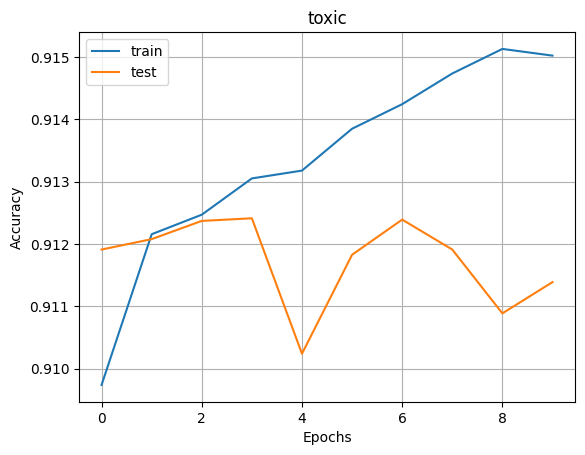

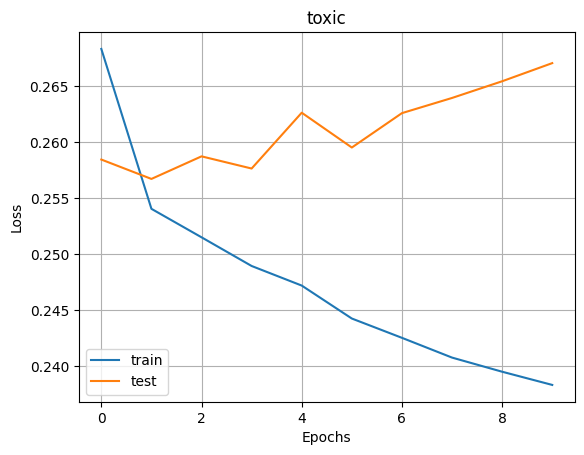

------------------------------------------------------------------------------------------------------


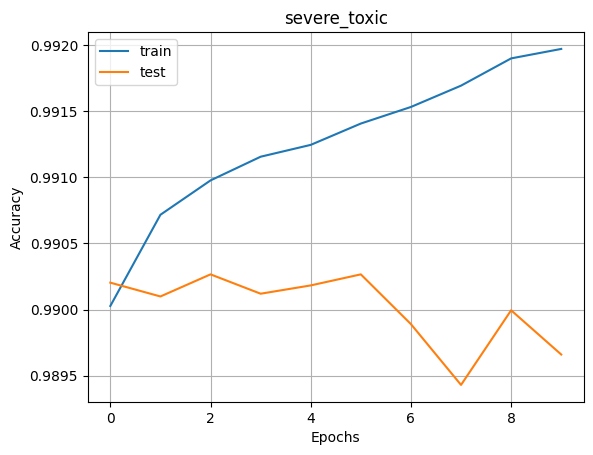

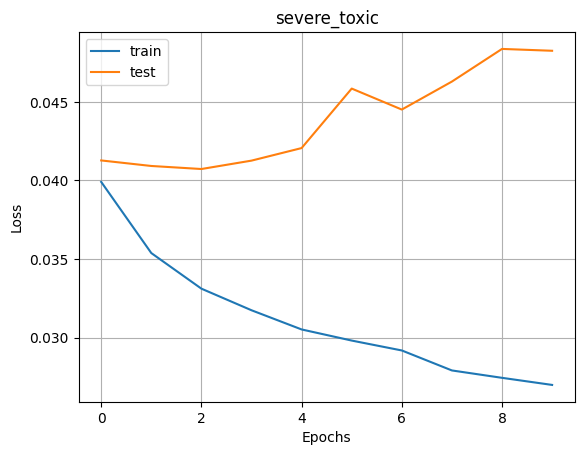

------------------------------------------------------------------------------------------------------


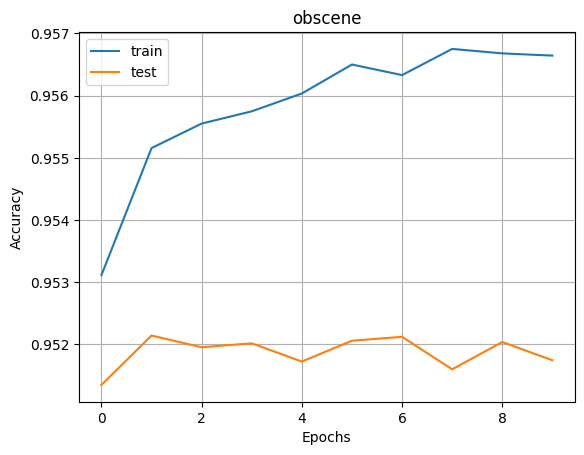

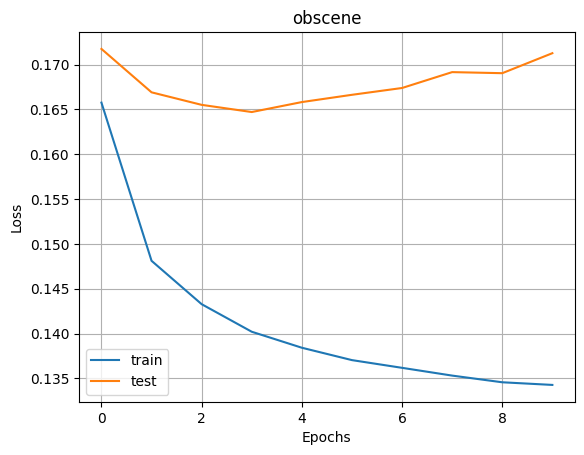

------------------------------------------------------------------------------------------------------


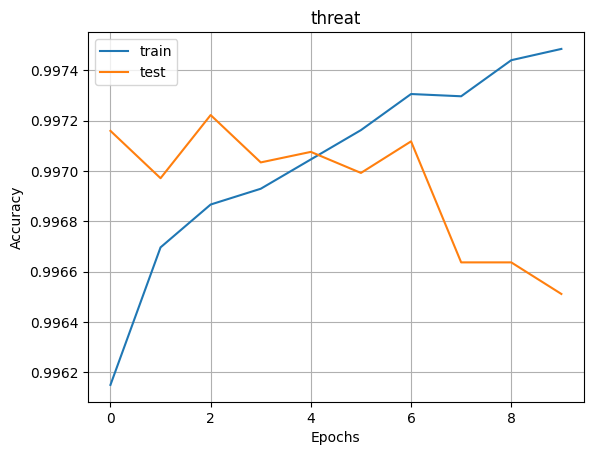

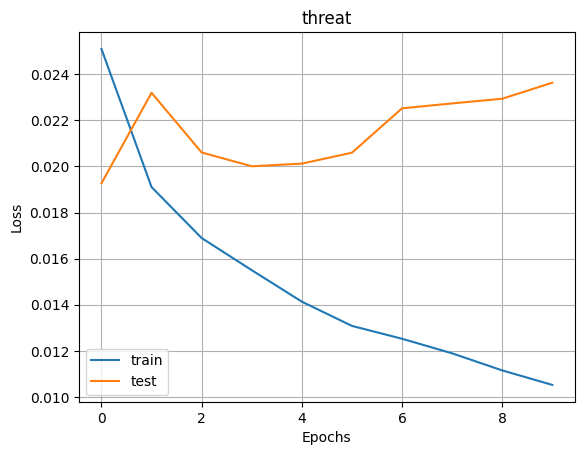

------------------------------------------------------------------------------------------------------


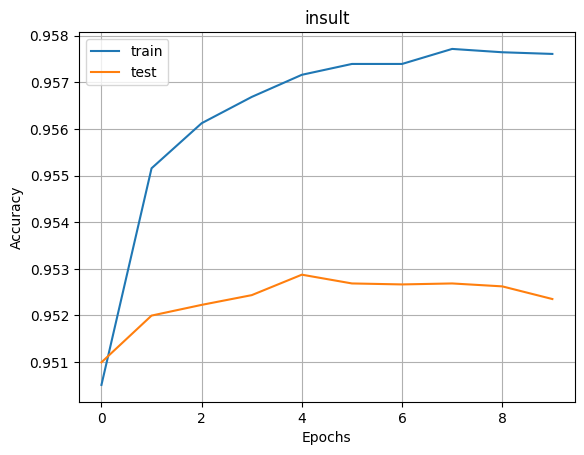

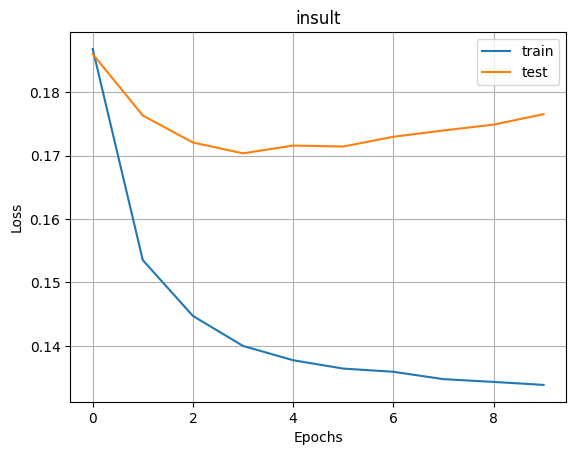

------------------------------------------------------------------------------------------------------


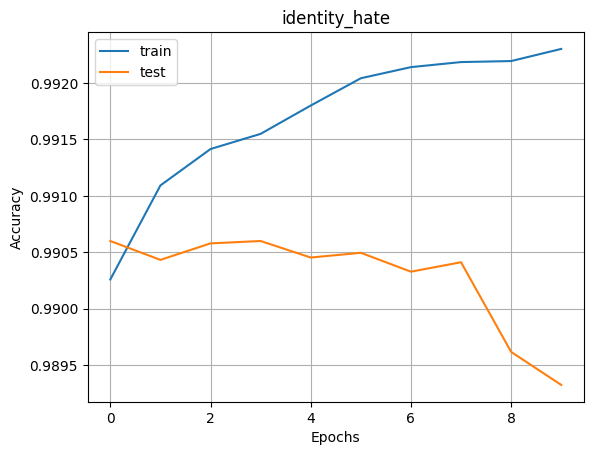

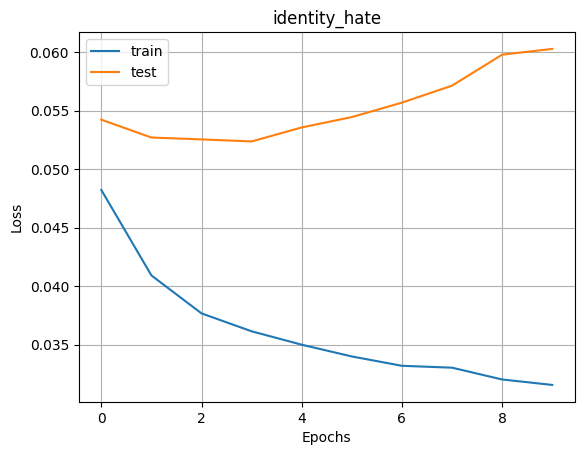

------------------------------------------------------------------------------------------------------


In [44]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch

    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("------------------------------------------------------------------------------------------------------")

#### 4.1.2) Word2vec Embeddings

In [45]:
EMBD_DIM = 200
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/Word2Vec/"

In [46]:
sentences_split = train_df["clean_comments"].apply(lambda x: x.split()).to_list()
w2v = Word2Vec(sentences_split, vector_size=EMBD_DIM, window=5, min_count=5, negative=15, workers=multiprocessing.cpu_count())
word_vectors = w2v.wv
filepath = "/content/drive/MyDrive/NLP - ENSAE/project_embd_w2v.txt"
word_vectors.save_word2vec_format(filepath, binary=False)

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_split)
sequences = tokenizer.texts_to_sequences(sentences_split)
padded_sentences = pad_sequences(sequences, maxlen=MAX_LEN)

In [48]:
print("Vocabulary size:", len(word_vectors))
print()
result = word_vectors.similar_by_word("bitch")
print(result[:3])
print()
result = word_vectors.most_similar("fuck")
print(result[:3])
print()
result = word_vectors.most_similar_cosmul("fat")
print(result[:3])
print()
result = word_vectors.most_similar_cosmul(positive = ["kill", "gay"])
print(result[:3])

Vocabulary size: 44243

[('motherfucker', 0.7954314351081848), ('whore', 0.7585481405258179), ('prick', 0.7576482892036438)]

[('niggertard', 0.7173468470573425), ('cunt', 0.6353803873062134), ('wtf', 0.6075383424758911)]

[('bitches', 0.8959823846817017), ('dumbass', 0.8696353435516357), ('sannse', 0.8683571219444275)]

[('queer', 0.6064721941947937), ('gays', 0.6050541996955872), ('homosexual', 0.5962139368057251)]


In [49]:
embedding_index = {}
f = open(os.path.join(filepath), encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close()

In [50]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBD_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [51]:
model_w2v = Sequential()
embedding_layer = Embedding(num_words, EMBD_DIM,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=MAX_LEN,
                           trainable=False)
model_w2v.add(embedding_layer)
model_w2v.add(Flatten())
model_w2v.add(Dense(1, activation='sigmoid'))
model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)

    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_w2v = model_w2v.fit(X_train_pad, y_train, batch_size=128, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0

    y_pred_w2v = (model_w2v.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_w2v = y_pred_w2v[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_w2v))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
873/873 [==============================] - 7s 7ms/step - loss: 0.2110 - accuracy: 0.9375 - val_loss: 0.2027 - val_accuracy: 0.9419
Epoch 2/10
873/873 [==============================] - 5s 5ms/step - loss: 0.1516 - accuracy: 0.9505 - val_loss: 0.2119 - val_accuracy: 0.9428
Epoch 3/10
873/873 [==============================] - 5s 6ms/step - loss: 0.1394 - accuracy: 0.9538 - val_loss: 0.2317 - val_accuracy: 0.9432
Epoch 4/10
873/873 [==============================] - 5s 5ms/step - loss: 0.1350 - accuracy: 0.9550 - val_loss: 0.2399 - val_accuracy: 0.9400
Epoch 5/10
873/873 [==============================] - 5s 6ms/step - loss: 0.1285 - accuracy: 0.9567 - val_loss: 0.2448 - val_accuracy: 0.9407
Epoch 6/10
873/873 [==============================] - 5s 6ms/step - loss: 0.1258 - accuracy: 0.9581 - val_loss: 0.2490 - val_accuracy: 0.9409
Epoch 7/10
873/873 [==============================] - 5s 6ms/step - loss: 0.1193 - accuracy: 0.9583 - val_loss: 0.2646 - val_accuracy: 0.9401
Epoch 

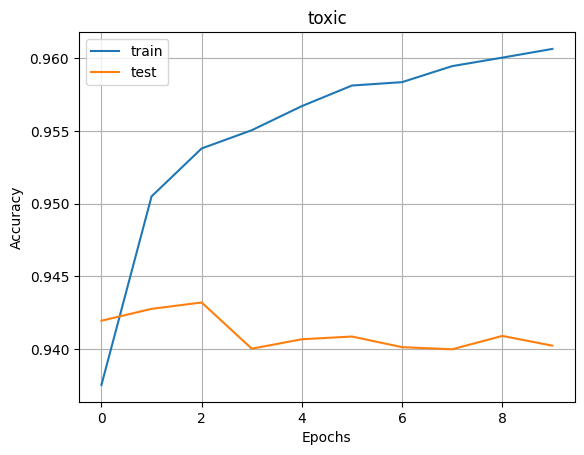

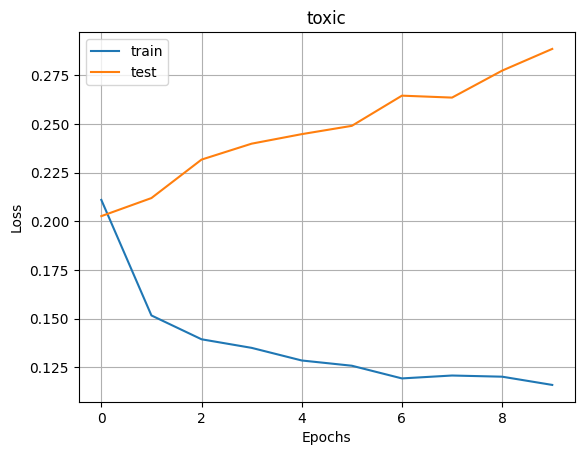

------------------------------------------------------------------------------------------------------


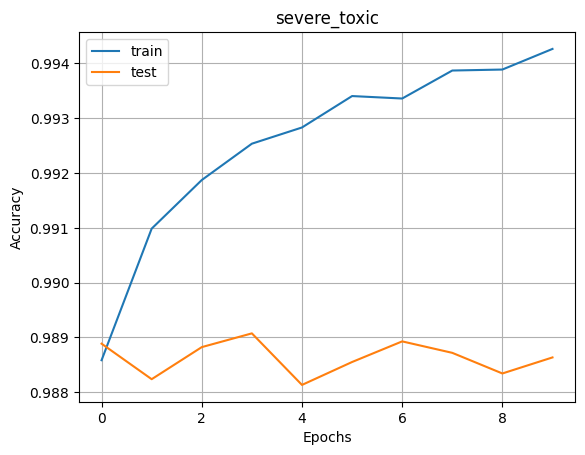

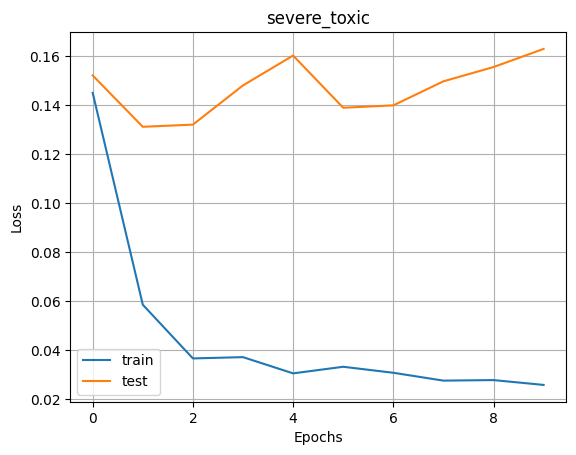

------------------------------------------------------------------------------------------------------


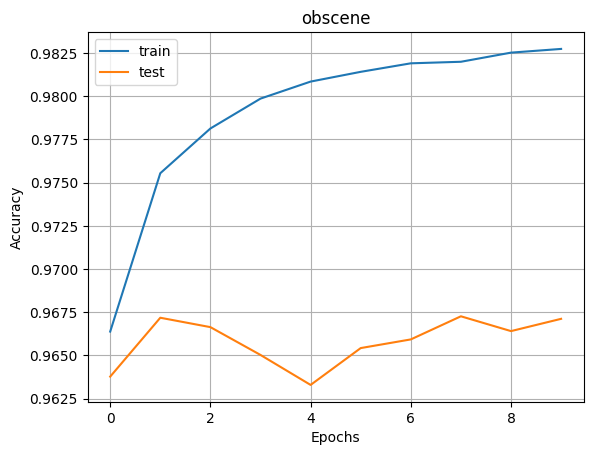

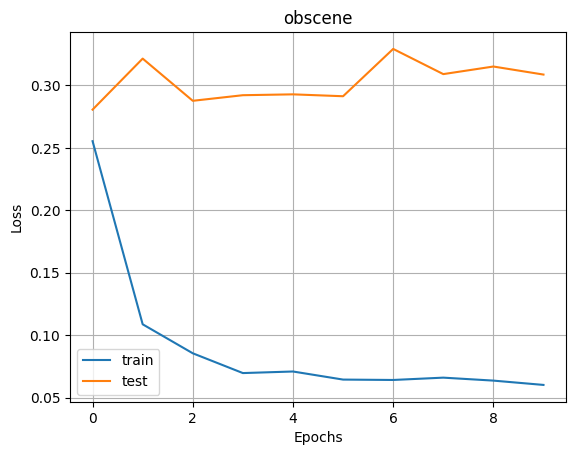

------------------------------------------------------------------------------------------------------


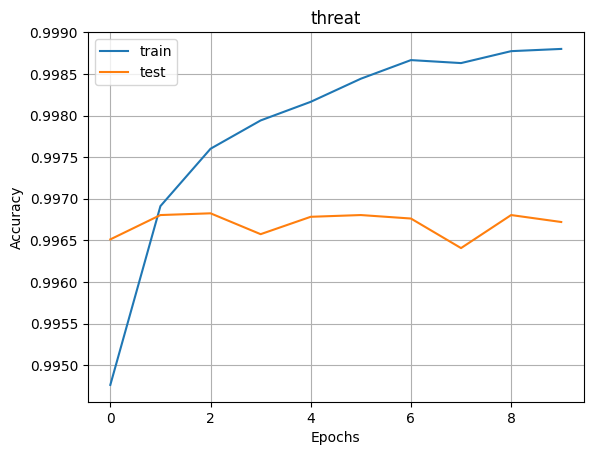

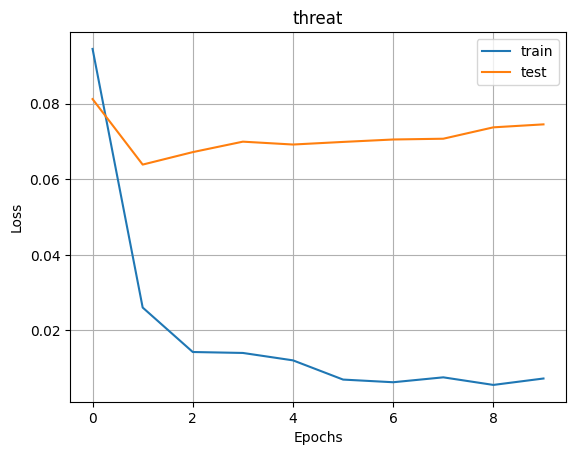

------------------------------------------------------------------------------------------------------


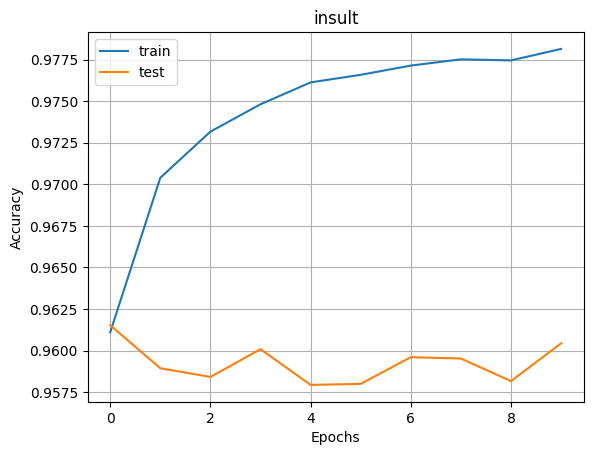

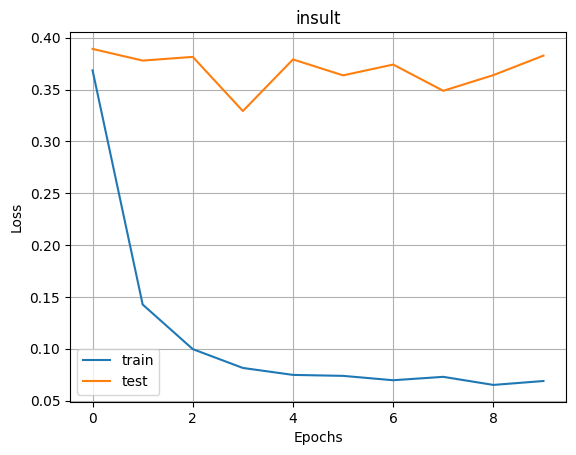

------------------------------------------------------------------------------------------------------


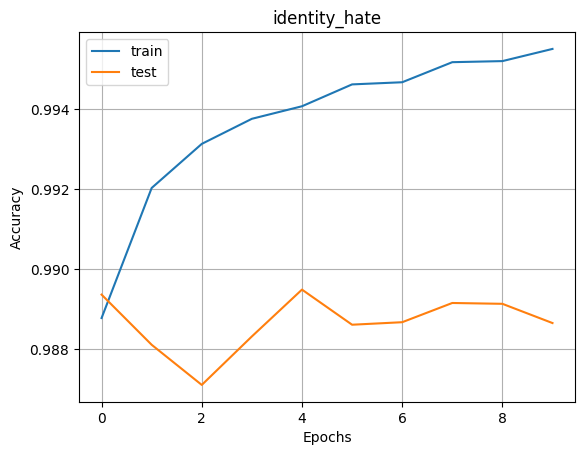

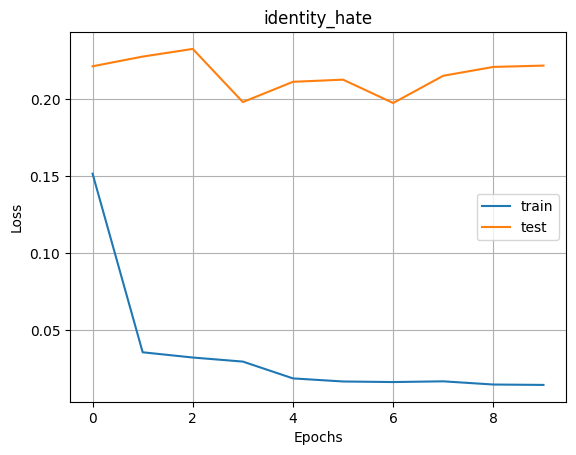

------------------------------------------------------------------------------------------------------


In [53]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch

    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("------------------------------------------------------------------------------------------------------")

#### 4.1.3) Glove Embeddings

In [54]:
EMBD_DIM = 100
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/Glove/"

In [55]:
sentences = train_df["clean_comments"].to_list()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(sequences, MAX_LEN, padding='post')

In [56]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/NLP - ENSAE/glove.6B.100d.txt', encoding="utf8")

In [57]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [58]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBD_DIM))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [59]:
model_Glove = Sequential()
embedding_layer = Embedding(num_words, EMBD_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)
model_Glove.add(embedding_layer)
model_Glove.add(Flatten())
model_Glove.add(Dense(1, activation='sigmoid'))
model_Glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
import os

# Specify the directory path
directory = '/content/drive/MyDrive/NLP - ENSAE/Models/Glove/'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)

    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_Glove = model_Glove.fit(padded_sentences, target, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0

    y_pred_Glove = (model_Glove.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_Glove = y_pred_Glove[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_Glove))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
4987/4987 [==============================] - 20s 4ms/step - loss: 0.3803 - accuracy: 0.9042 - val_loss: 0.3161 - val_accuracy: 0.9041
Epoch 2/10
4987/4987 [==============================] - 17s 3ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_accuracy: 0.9041
Epoch 3/10
4987/4987 [==============================] - 18s 4ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_accuracy: 0.9041
Epoch 4/10
4987/4987 [==============================] - 21s 4ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_accuracy: 0.9041
Epoch 5/10
4987/4987 [==============================] - 17s 3ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_accuracy: 0.9041
Epoch 6/10
4987/4987 [==============================] - 18s 4ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_accuracy: 0.9041
Epoch 7/10
4987/4987 [==============================] - 18s 4ms/step - loss: 0.3159 - accuracy: 0.9042 - val_loss: 0.3160 - val_ac

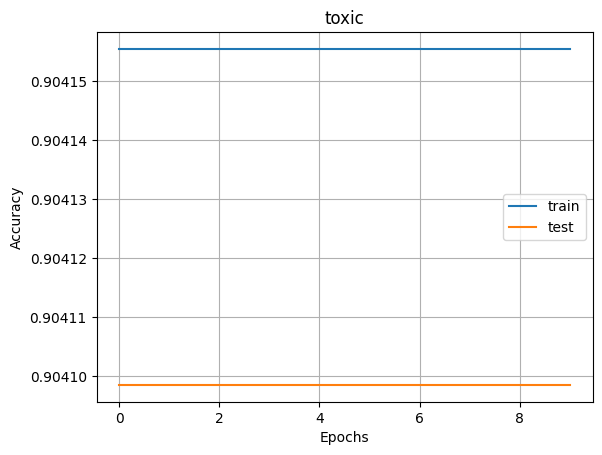

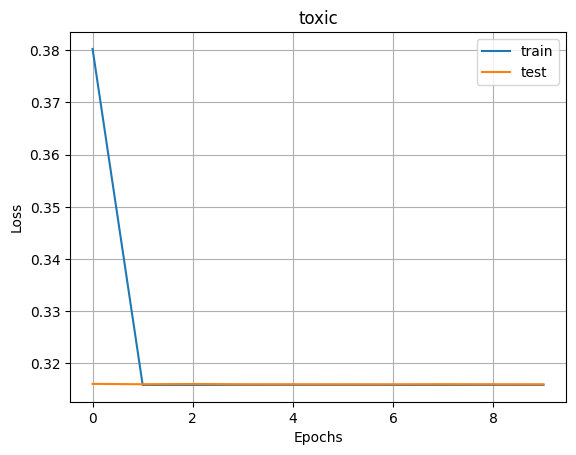

------------------------------------------------------------------------------------------------------


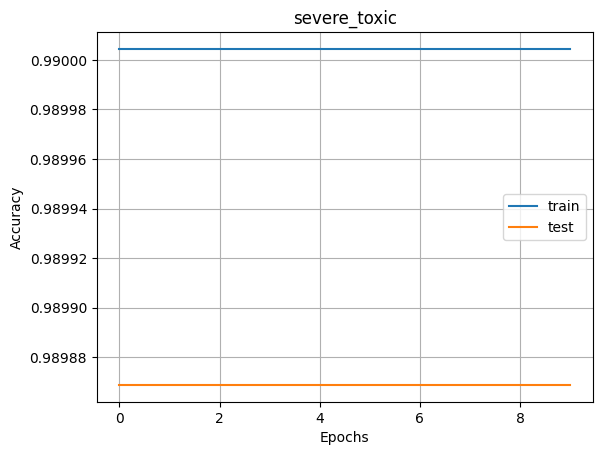

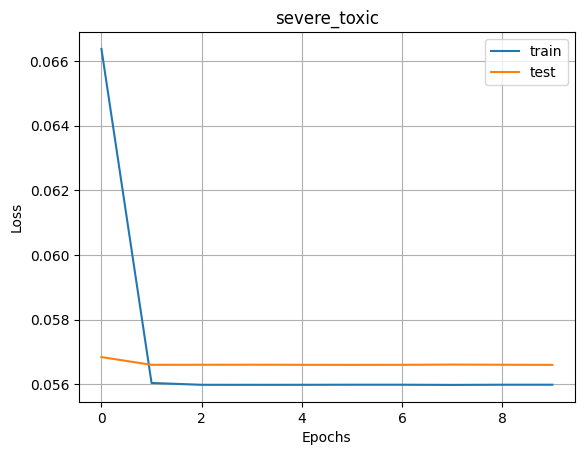

------------------------------------------------------------------------------------------------------


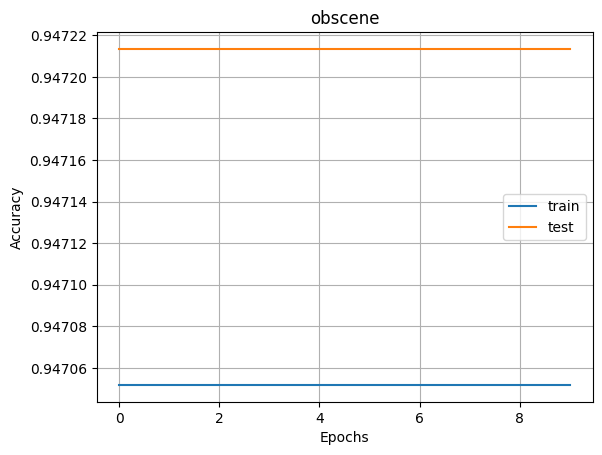

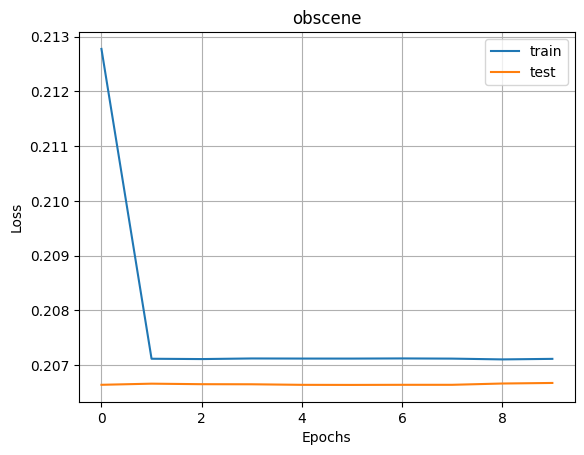

------------------------------------------------------------------------------------------------------


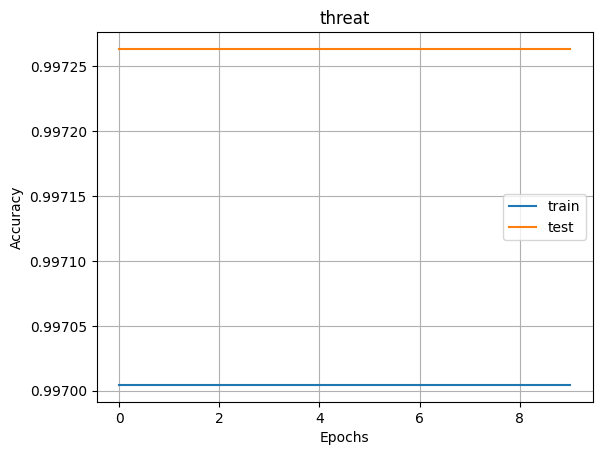

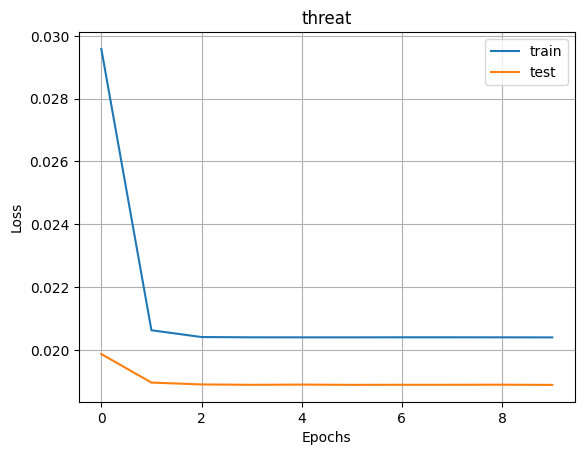

------------------------------------------------------------------------------------------------------


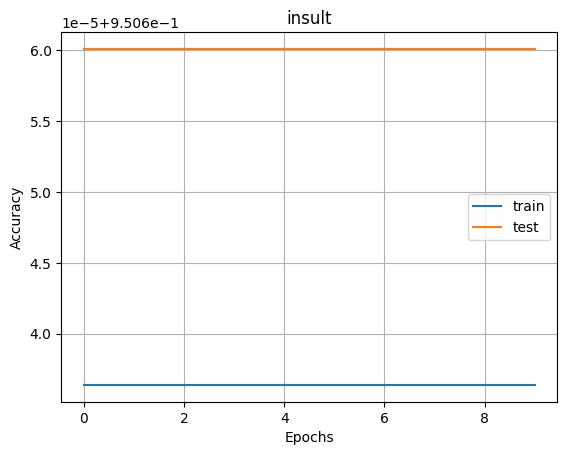

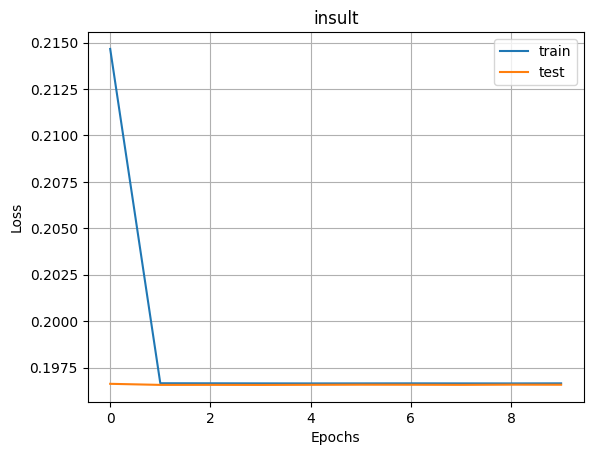

------------------------------------------------------------------------------------------------------


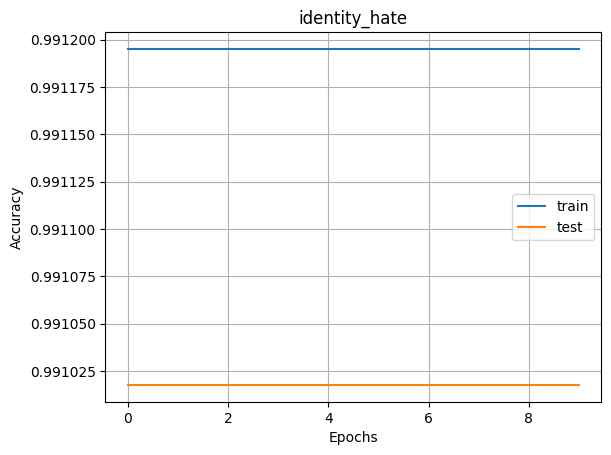

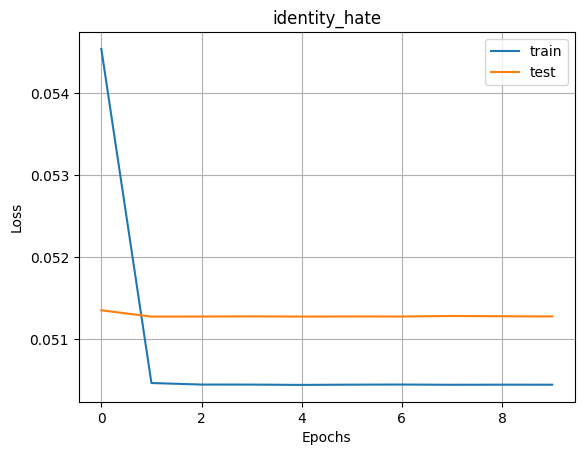

------------------------------------------------------------------------------------------------------


In [61]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch

    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("------------------------------------------------------------------------------------------------------")

### 4.2) Multi tasks model

#### 4.2.1)  LSTM

In [62]:
y = train_df[types].values

In [63]:
max_features = 20000
maxlen = 200
sentences = train_df["clean_comments"].to_list()
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(sequences, maxlen, padding='post')

In [64]:
X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, y, test_size=0.3, random_state=0)

In [65]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
batch_size = 32
epochs = 2
model.fit(X_train_pad, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
3142/3142 [==============================] - 993s 315ms/step - loss: 0.1484 - accuracy: 0.9059 - val_loss: 0.1386 - val_accuracy: 0.9944
Epoch 2/2
3142/3142 [==============================] - 943s 300ms/step - loss: 0.1418 - accuracy: 0.9881 - val_loss: 0.1403 - val_accuracy: 0.9944


In [67]:
y_pred = model.predict([X_test_pad], batch_size=1024, verbose=1)

47/47 [==============================] - 2s 33ms/step


In [68]:
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1

In [69]:
y_int = pd.DataFrame(y_int)
y_int.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)

In [70]:
y_test_l = pd.DataFrame(y_test)
y_test_l.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)

In [71]:
for i in types:
    yi_pred = y_int[i]
    yi_test = y_test_l[i]
    print('Accuracy: %.4f' % accuracy_score(yi_test, yi_pred))

Accuracy: 0.9041
Accuracy: 0.9899
Accuracy: 0.9472
Accuracy: 0.9973
Accuracy: 0.9507
Accuracy: 0.9910


In [72]:
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

Accuracy is 0.897894385026738


#### 4.2.2) BERT

In [73]:
bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [74]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )

        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

In [75]:
def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

In [76]:
input_ids = tokenize_sentences(train_df['clean_comments'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [77]:
labels =  train_df[types].values
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.3)
train_masks, test_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.3)

train_size = len(train_inputs)
test_size = len(test_inputs)

In [78]:
def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)

    return dataset

In [79]:
#Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [80]:
BATCH_SIZE=32
NR_EPOCHS=2

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
test_dataset = create_dataset((test_inputs, test_masks, test_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [81]:
class BertClassifier(tf.keras.Model):
        def __init__(self, bert: TFBertModel, num_classes: int):
            super().__init__()
            self.bert = bert
            self.classifier = Dense(num_classes, activation='sigmoid')

        @tf.function
        def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
            outputs = self.bert(input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   head_mask=head_mask)
            cls_output = outputs[1]
            cls_output = self.classifier(cls_output)

            return cls_output

In [82]:
model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(types))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [83]:
lw = 2
steps_per_epoch = train_size // BATCH_SIZE
test_steps = test_size // BATCH_SIZE

In [84]:
# Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [85]:
# Optimizer
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = tf.keras.optimizers.Adam(lr=2e-5)

In [86]:
# Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(types))]
test_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(types))]

In [87]:
@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)
    #Loss Function into gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    #Apply gradient to optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [88]:
@tf.function
def test_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    for i, auc in enumerate(test_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [89]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_class = 6

In [90]:
def train(model, train_dataset, test_dataset, train_steps_per_epoch, test_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch+1}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 500 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(types):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()

        for i, (token_ids, masks, labels) in enumerate(tqdm(test_dataset, total=test_steps_per_epoch)):
            test_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {test_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(types):
            print(f"{label_name} roc_auc {test_auc_metrics[i].result()}")
            test_auc_metrics[i].reset_states()

        print('\n')

In [ ]:
train(model, train_dataset, test_dataset, steps_per_epoch, test_steps, NR_EPOCHS)

================================================== EPOCH 1 ==================================================


  0%|          | 0/3490 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.7599329352378845
toxic roc_auc 0.5977011919021606
severe_toxic roc_auc 0.22580647468566895
obscene roc_auc 0.11290323734283447
threat roc_auc 0.0
insult roc_auc 0.0
identity_hate roc_auc 0.0

Train Step: 500, Loss: 0.16997212171554565
toxic roc_auc 0.48533689975738525
severe_toxic roc_auc 0.46168485283851624
obscene roc_auc 0.48200246691703796
threat roc_auc 0.48749130964279175
insult roc_auc 0.48209676146507263
identity_hate roc_auc 0.49767816066741943

Train Step: 1000, Loss: 0.15600912272930145
toxic roc_auc 0.48832330107688904
severe_toxic roc_auc 0.5106059312820435
obscene roc_auc 0.4981451630592346
threat roc_auc 0.5341848731040955
insult roc_auc 0.48201173543930054
identity_hate roc_auc 0.48497241735458374

Train Step: 1500, Loss: 0.15271957218647003
toxic roc_auc 0.503672182559967
severe_toxic roc_auc 0.4657227098941803
obscene roc_auc 0.5032937526702881
threat roc_auc 0.485000342130661
insult roc_auc 0.4963497817516327
identity_hate roc_auc 0.4967826604